In [106]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100
import plotly.graph_objects as go
from scipy.optimize import fsolve
# import warnings
# warnings.filterwarnings("error")

In [107]:
arr = np.ones(5)
print(arr)
i = 5
np.sum(arr[4:])

[1. 1. 1. 1. 1.]


1.0

In [51]:
T = 0.5

a = 0
b = 1

h = 0.01
tau = 0.01

M = int(T/tau) + 1
N = int((b-a)/h) + 1

U = np.zeros((M, N))
Q = np.zeros(N)
Psi = np.ones(N-1)
Psis = [Psi.copy()]

Kuxt = lambda u, x, t: u**2
K = lambda m, n: Kuxt(U[m][n], n*h, m*tau)

for n in range(N):
    U[0][n] = 0
    # U[0][n] = -40*((n*h)-0.5)**2+10
    # U[0][n] = 10*np.sin(10*n*h)

for m in range(1, M):
    def F(Q_m):
        F_retuned = np.zeros(N)
        F_retuned[0] = Q_m[0]
        for i in range(1, N-1):
            alpha = 0.001
            A = (0.5-alpha)*Q_m[i-1]+(0.5+alpha)*Q_m[i+1]+h/tau*((0.5-alpha)*Psi[i-1] - (0.5+alpha)*Psi[i])
            B = (0.5+alpha)*Q_m[i-1]+(0.5-alpha)*Q_m[i+1]+h/tau*((0.5+alpha)*Psi[i-1] - (0.5-alpha)*Psi[i])
            if np.abs(U[m-1][i+1] - U[m-1][i-1]) < 0.0000001:
                if (K(m-1, i+1)*(U[m-1][i+1] - U[m-1][i]) - \
                    K(m-1, i-1)*(U[m-1][i] - U[m-1][i-1])) * \
                    2/h/(Psi[i]+Psi[i-1]) * (U[m-1][i+1] - U[m-1][i-1]) < 0:
                    F_retuned[i] = A - Q_m[i]
                else:
                    F_retuned[i] = B - Q_m[i]
            else:
                Q_counted = (K(m-1, i+1)*(U[m-1][i+1] - U[m-1][i]) - \
                        K(m-1, i-1)*(U[m-1][i] - U[m-1][i-1])) * \
                        2/h/(Psi[i]+Psi[i-1])/(U[m-1][i+1] - U[m-1][i-1])
                if Q_counted < Q_m[i+1] - h/tau*Psi[i]:
                    F_retuned[i] = A - Q_m[i]
                elif Q_counted > Q_m[i-1] + h/tau*Psi[i-1]:
                    F_retuned[i] = B - Q_m[i]
                else:
                    F_retuned[i] = Q_counted - Q_m[i]
        F_retuned[N-1] = Q_m[N-1]
        return F_retuned
    Q = fsolve(F, h*np.ones(N))
    # Q[0] = 0
    # for i in range(1, N - 1):
    #     # if np.abs(A[m-1][i+1] - A[m-1][i-1]) < 0.01 or np.abs(Psi[i]+Psi[i-1]) < 0.01:
    #     #     Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
    #     #             K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
    #     #             2/h/0.01/ 0.01
    #     # else:
    #     #     try:
    #     #         Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
    #     #                 K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
    #     #                 2/h/(Psi[i]+Psi[i-1])/(A[m-1][i+1] - A[m-1][i-1])
    #     #     except:
    #     #         pass
    #     # if Psi[i-1] + tau/h*(Q[i-1]-Q[i]) < 0:
    #     #     Q[i] = h/tau*Psi[i-1]/2 + Q[i-1]
    #     # else:
    #     #     Q[i] += h/tau*Psi[i-1]/2 + Q[i-1]
    #     counted = (K(m-1, i+1)*(U[m-1][i+1] - U[m-1][i]) - \
    #                 K(m-1, i-1)*(U[m-1][i] - U[m-1][i-1])) * \
    #                 2/h/(Psi[i]+Psi[i-1])/(U[m-1][i+1] - U[m-1][i-1])
    #     right =  h/tau*np.min(Psi[:i])
    #     left = -h/tau*np.min(Psi[i:])
    #     if left < counted < right:
    #         Q[i] = counted
    #     elif counted > right:
    #         Q[i] = right/2
    #     elif counted < left:
    #         Q[i] = left/2
    #     # Q[i] = (left+right)/2
    #     # Q[i] = 0
    # Q[N-1] = 0

    Psi_next = np.ones(N-1)
    for i in range(0, N-1):
        Psi_next[i] = Psi[i] + tau/h*(Q[i]-Q[i+1])
            
    A = np.zeros((N, N))
    B = np.zeros(N)
    for n in range(0, N):
        if n == 0:
            A[n][0] = 1
            B[n] = 1
        elif n == N-1:
            A[n][N-1] = 1
            B[n] = 0
        else:
            Psi_nM1 = (Psi[n-2] + Psi[n-1])/2
            Psi_n = (Psi[n-1] + Psi[n])/2
            Psi_nP1 = (Psi[n] + Psi[n] if n == N-2 else 2*Psi[n+1])/2
            Psi_n_next = (Psi_next[n-1] + Psi_next[n])/2
            A[n][n-1] = tau/2/h**2*(K(m-1, n)/Psi_n+K(m-1, n-1)/Psi_nM1)
            A[n][n] = -(Psi_n_next+tau/2/h**2*(K(m-1, n+1)/Psi_nP1+2*K(m-1, n)/Psi_n+K(m-1, n-1)/Psi_nM1))
            A[n][n+1] = tau/2/h**2*(K(m-1, n+1)/Psi_nP1+K(m-1, n)/Psi_n)
            B[n] = tau/h*(Q[n+1]*U[m-1][n+1]-Q[n]*U[m-1][n])-Psi_n*U[m-1][n]
        
    X = np.linalg.inv(A).dot(B)
    U[m] = X

    Psi = Psi_next.copy()
    
    Psis.append(Psi.copy())

c:\Users\stas2\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\stas2\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [31]:
Psi

array([0.11332801, 0.10888377, 0.10461382, 0.10888377, 0.11332801,
       0.10888377, 0.11332801, 0.11795364, 0.11332801, 0.10888377,
       0.11332801, 0.11795364, 0.12276807, 0.12777902, 0.13299449,
       0.13842283, 0.14407274, 0.14995327, 0.15607381, 0.16244417,
       0.16907454, 0.17597554, 0.18315822, 0.19063406, 0.19841504,
       0.20651362, 0.21494275, 0.22371592, 0.23284718, 0.24235115,
       0.25224303, 0.26253866, 0.27325453, 0.28440777, 0.29601625,
       0.30809855, 0.320674  , 0.33376274, 0.34738571, 0.36156471,
       0.37632246, 0.39168256, 0.4076696 , 0.42430918, 0.44162792,
       0.45965355, 0.47841492, 0.49794206, 0.51826622, 0.53941995,
       0.56143709, 0.58435289, 0.60820402, 0.63302868, 0.65886658,
       0.6857591 , 0.71374926, 0.74288189, 0.7732036 , 0.80476293,
       0.83761039, 0.87179857, 0.90738219, 0.9444182 , 0.98296588,
       1.02308693, 1.06484558, 1.10830867, 1.15354576, 1.20062926,
       1.24963453, 1.30064002, 1.35372737, 1.40898155, 1.46649

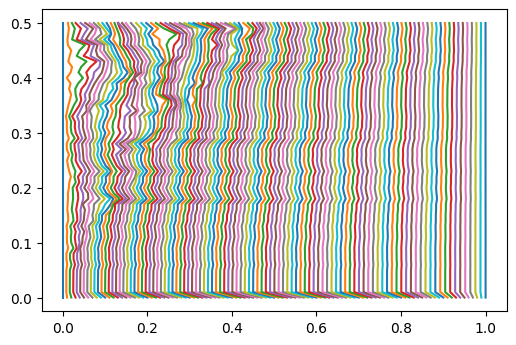

In [52]:
t = 0
graph = []
for i, Psi in enumerate(Psis):
    if i % 1 == 0:
        X = list()
        xi = 0
        X.append(xi)
        for psi in Psi:
            xi += psi * h
            X.append(xi)
        graph.append([X, list(np.full((len(X)), t))])
        # plt.scatter(X, np.full((len(X)), t), s=1, color='black')
        t += tau
graph = np.array(graph)
graph = graph.transpose()
# graph.shape, graph[0]
for l in graph:
    # l = line.transpose()
    plt.plot(l[0], l[1])
plt.show()

In [ ]:
sh_0, sh_1 = A.shape
fig = go.Figure()
fig.add_surface(
    # contours = {
    #     "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
    #     "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    # },
    x = np.linspace(a, b, sh_1),
    y = np.linspace(0, T, sh_0),
    z = U
    )
# fig.add_scatter3d(name='scat_p', x=np.linspace(a, b, sh_1), y=np.linspace(0, T, sh_0), z=U, mode='markers',
#     marker=dict(size=10, color='black',colorscale='Reds'))
# fig.update_layout(
#         scene = {
#             "xaxis": {"nticks": 20},
#             "zaxis": {"nticks": 4},
#             'camera_eye': {"x": 0, "y": -1, "z": 0.5},
#             "aspectratio": {"x": 1, "y": 1, "z": 0.2}
#         })
fig.update_layout(title='surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=5, r=50, b=5, t=55))
fig.show()